In [2]:
import torch
import numpy as np
from torch.autograd import Variable

#from bokeh.plotting import *
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import PIL
from IPython import display
dtypeF = torch.FloatTensor
dtypeI = torch.LongTensor

import multiprocessing as mp

In [3]:
def simple_mle_train():
    lr = 3 * 1e-2
    np.random.shuffle(data)
    print('training data', data)

    torch.manual_seed(1374)
    s = Variable(torch.randn(n_items).type(dtypeF), requires_grad=True)
    # p = Variable(torch.randn(1).type(dtypeF), requires_grad=False)
    # print(s,i,j)
    s.data /= torch.sum(s.data)
    # print(s)
    p_list = []
    p_noreg_list = []
    for _ in range(1000):
        np.random.shuffle(data)

        p = 0
        for i, j in data:
            p += - torch.log(torch.exp((s[j] - s[i])) + 1)

        p_noreg_list.append(np.array(p.data)[0])
        p += - 0.1 * s.pow(2).sum()
        p_list.append(np.array(p.data)[0])
        p.backward()
        s.data += lr * s.grad.data
    #     s.data /= torch.sum(s.data)

        s.grad.data.zero_()

    res_s = s.data.cpu().numpy()
    rank = np.argsort(res_s)
    plt.plot(p_list)
    plt.show()
    # plt.plot(p_noreg_list)
    # plt.show()
    print('predicted rank', rank, res_s[rank])

training data [(1, 0), (0, 2), (0, 4), (2, 4), (4, 3), (3, 1)]


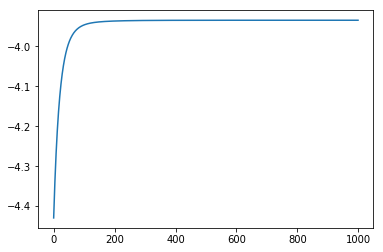

predicted rank [4 3 2 1 0] [-0.45549253 -0.11897874  0.0004868   0.11995256  0.45646611]
ground truth rank [4, 3, 2, 1, 0]
CPU times: user 723 ms, sys: 440 ms, total: 1.16 s
Wall time: 665 ms


In [4]:
%%time
#toy data from https://github.com/lucasmaystre/choix

n_items = 5
m_judges = 1
data = [
    (1, 0), (0, 4), (3, 1),
    (0, 2), (2, 4), (4, 3),
]
simple_mle_train()
gt_rank = [4, 3, 2, 1, 0]
print('ground truth rank', gt_rank)



training data [(4, 5), (6, 5), (2, 3), (7, 3), (5, 4), (7, 0), (3, 4), (6, 5), (3, 2), (2, 0), (4, 0), (0, 4), (3, 4), (7, 6), (2, 1), (5, 2), (4, 2), (7, 3), (6, 3), (5, 2)]


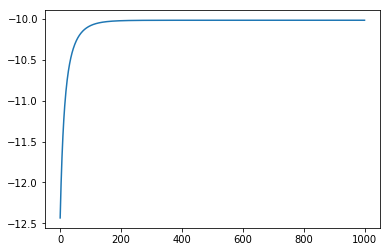

predicted rank [1 0 2 4 5 3 6 7] [ -1.50783527e+00  -1.06559682e+00  -6.68293178e-01  -6.20043874e-01
  -1.21566351e-03   1.49666416e-02   1.45301473e+00   2.39743829e+00]
ground truth rank [1 0 2 4 5 3 6 7] [-2.927 -1.198 -0.797 -0.742 -0.15  -0.126  2.019  3.922]
CPU times: user 1.28 s, sys: 153 ms, total: 1.44 s
Wall time: 1.27 s


In [5]:
%%time

n_items = 8
data = [
    (7, 3), (2, 0), (5, 2), (4, 2), (2, 1),
    (4, 5), (6, 3), (5, 4), (7, 0), (2, 3),
    (4, 0), (0, 4), (6, 5), (3, 2), (3, 4),
    (3, 4), (5, 2), (7, 3), (7, 6), (6, 5),
]
simple_mle_train()
gt_mean = np.array([-1.198,-2.927,-0.797,-0.126,-0.742,-0.15,2.019,3.922])
gt_rank = np.argsort(gt_mean)
print('ground truth rank', gt_rank, gt_mean[gt_rank])

In [6]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

def err_func(pred):
    return np.abs(np.arange(len(pred)) - pred).mean()

def async_train(fp, args_ls):
    
    def f(q, fp, args_l):
        print(args_l[1])
        res = fp(*args_l)
        q.put(res)
    result_err = []

    q = mp.Queue()
    ps = []
    for args_l in args_ls:
    #     rets = pool.apply_async(f, (q, np.arange(pid)))
        p = mp.Process(target=f, args=(q, fp, args_l))
        ps.append(p)
        p.start()

    for p in ps:
        result_err.append(q.get())

    for p in ps:
        p.join()
    
    return result_err

ground truth s [-0.01374931  0.00037793  0.00605697  0.01621291  0.03094453  0.03365585
  0.03473438  0.03477249  0.0369896   0.04531439  0.04543051  0.0523239
  0.05651231  0.0666977   0.06835611  0.07191181  0.07741502  0.08287674
  0.08958782  0.16357834]
ground truth beta [ 0.02242689  0.0430784   0.00342902  0.01457491  0.0111026 ]
0.999999998337
0.999999662657
0.771160265124
1.00000788065
1.00023018272


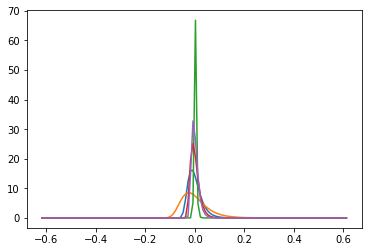

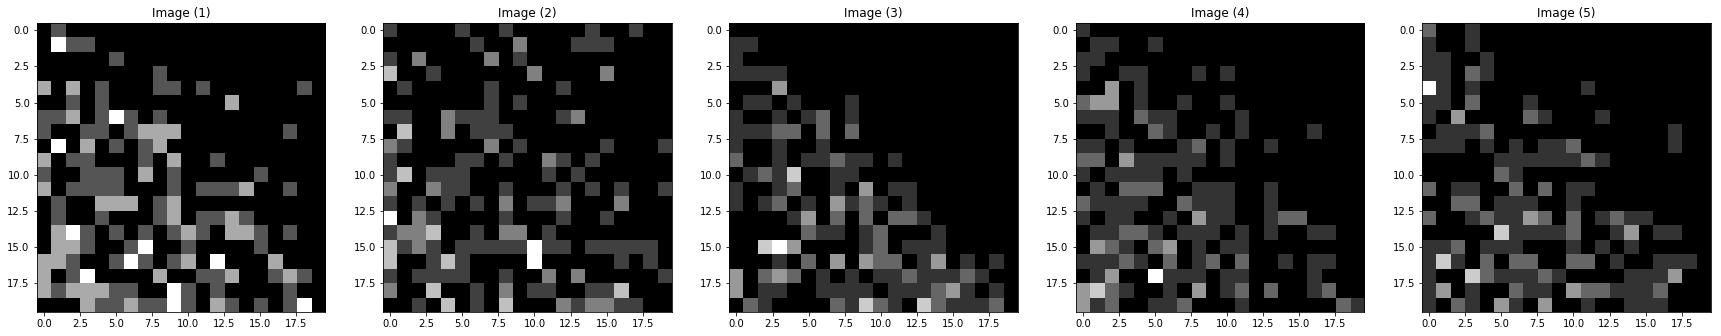

In [10]:
def generate_data(n_items=20, n_judges=5, n_pairs=200, beta_a=0.5, beta_b=20):

    s = np.sort(np.random.normal(loc=1.0, size=n_items))
    s /= s.sum()
    print('ground truth s', s)
#     betas = np.random.beta(beta_a, beta_b, size=n_judges)
    betas = np.random.random(size=n_judges) / beta_b
    print('ground truth beta', betas)

    def gb_cdf(x, beta):
        mu = -0.5772*beta
        return np.exp(-np.exp(-(x-mu)/beta) )

    def gb_pdf(x, beta):
        mu = -0.5772*beta
        return 1. / beta * np.exp(-(x-mu)/beta - np.exp(-(x-mu)/beta) )

    ts = np.arange(-.618, .618, 0.01)
    for beta_i in betas:
        ty = gb_pdf(ts, beta_i)
        plt.plot(ts, ty)
        print(ty.sum()/100.)
    plt.show()

    data = []
    judge_imgs = []
    for k, beta_i in enumerate(betas):

        data_img = np.zeros((n_items, n_items))
        for _ in range(n_pairs):
            i = np.random.randint(0, len(s)) # try normal
            j = np.random.randint(0, len(s))

            s_i = s[i] + np.random.gumbel(-0.5772*beta_i, beta_i)
            s_j = s[j] + np.random.gumbel(-0.5772*beta_i, beta_i)
            if s_i > s_j:
                data.append((i, j, k))
                data_img[i][j] += 1. # rgb
            else:
                data.append((j, i, k))
                data_img[j][i] += 1. # rgb
        judge_imgs.append(data_img)

    show_images(judge_imgs, cols=1)
    len(data)
    return [data, n_items, n_judges, n_pairs]

data_pack = generate_data()

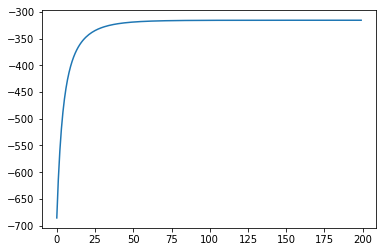

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15775871 -3.02529716 -2.30527711 -1.89492023 -1.75579572 -1.30490053
 -0.69415271 -0.58347261 -0.31363428 -0.08820155 -0.07040966  0.18033569
  0.56446475  1.14620197  1.60085726  1.77961826  1.82567906  2.04283237
  3.00019646  3.18761921]


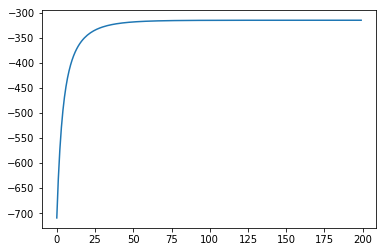

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15772843 -3.02526951 -2.30525851 -1.89490736 -1.7557857  -1.30488968
 -0.69414788 -0.58346754 -0.31363142 -0.08820065 -0.07041065  0.18033519
  0.56446064  1.14619422  1.60084832  1.77960563  1.82566595  2.04281521
  3.000175    3.18758345]


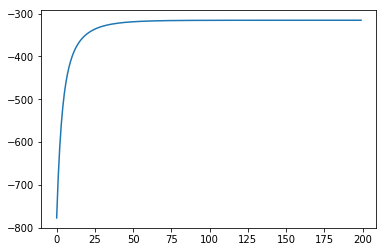

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15763092 -3.02517962 -2.30519342 -1.89486206 -1.75574958 -1.30485106
 -0.69412887 -0.58344734 -0.31361866 -0.08819419 -0.07041071  0.18033604
  0.56444979  1.14616823  1.60082245  1.77956128  1.82562482  2.04274988
  3.00006247  3.18747735]


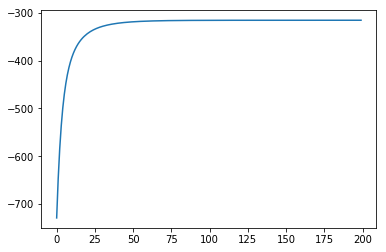

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15784883 -3.02537632 -2.30533934 -1.89496613 -1.75583351 -1.30493951
 -0.69417417 -0.58349514 -0.31364956 -0.08821071 -0.07041228  0.18033189
  0.56447256  1.14622521  1.60087967  1.77966082  1.82571769  2.04289746
  3.00031686  3.18773031]


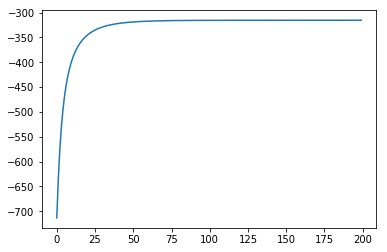

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15771651 -3.02525949 -2.30524874 -1.89489973 -1.75577939 -1.30488324
 -0.69414371 -0.58346313 -0.31362817 -0.08819817 -0.07040927  0.1803367
  0.56446058  1.146191    1.60084653  1.77959859  1.82566106  2.04280353
  3.00014567  3.18757176]


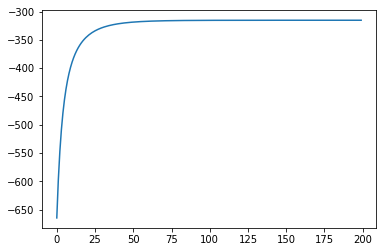

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15782166 -3.02535629 -2.30532169 -1.89495337 -1.7558229  -1.30492878
 -0.69416821 -0.58348876 -0.31364539 -0.0882082  -0.07041156  0.18033297
  0.56447047  1.1462189   1.60087347  1.77965021  1.82570744  2.04287982
  3.00028467  3.18769765]


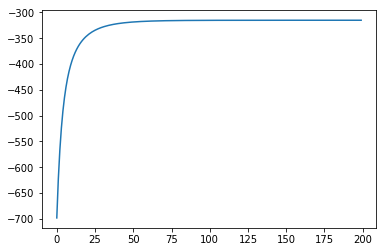

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15775943 -3.02530432 -2.30527973 -1.89492226 -1.75579786 -1.30490339
 -0.69415408 -0.58347422 -0.31363592 -0.08820292 -0.07041096  0.18033479
  0.56446433  1.14620304  1.60085714  1.77962148  1.82568049  2.04283738
  3.00021482  3.18761921]


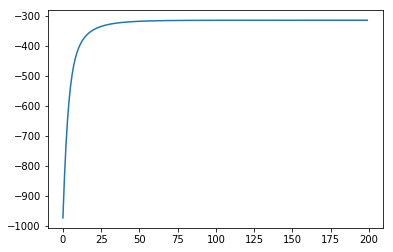

predicted rank without beta [ 1  0  2  3  4  5  7  6  8 10  9 11 12 13 14 17 15 16 18 19] [-3.15770769 -3.02523637 -2.3052485  -1.89490461 -1.75578558 -1.3048867
 -0.69415128 -0.5834704  -0.31363571 -0.08820572 -0.07041637  0.18032876
  0.56445324  1.14618599  1.60083783  1.77959347  1.82565594  2.04280829
  3.00016069  3.18760967]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [11]:
def train_func_torchy_simple(data_pack, int_seed=1362, max_iter=500, lr=1e-3, opt_func=torch.optim.SGD):

    data, n_items, n_judges, n_pairs = data_pack
    torch.manual_seed(int_seed)
    s = Variable(torch.randn(n_items).type(dtypeF), requires_grad=True)
    # print(s,i,j)
    s.data /= torch.sum(s.data)
    
    params = [s]
    optimizer = opt_func(params, lr=lr)

    # print(s)
    p_list = []
    p_noreg_list = []

    for iter_num in range(max_iter):
    #     print(iter_num)
        np.random.shuffle(data)

        p = 0
        p_noreg = 0
        for i, j, k in data:
            p += -torch.log(torch.exp((s[j] - s[i])) + 1)


        p_noreg_list.append(np.array(p.data)[0])

        p += - s.pow(2).sum()

        p_list.append(np.array(p.data)[0])

        optimizer.zero_grad()
        p = -p
        p.backward()

        optimizer.step()

        
    res_s = s.data.cpu().numpy()
    rank = np.argsort(res_s)
    plt.plot(p_list)
    plt.show()
    # plt.plot(p_noreg_list)
    # plt.show()
    print('predicted rank without beta', rank, res_s[rank])
    return err_func(rank)

# train_func_torchy_simple(data_pack=data_pack, max_iter=200, lr=5*1e-3, opt_func=torch.optim.ASGD)
args_ls = []
result_err = []
for sd in range(8):
    result_err.append(train_func_torchy_simple(*[data_pack, 1362+sd*44, 200, 5*1e-3, torch.optim.ASGD]))

print(result_err)

initial: s, eps [ 0.40646863 -0.80718607 -0.16755019  0.41735196 -0.75372607  0.32789445
  1.28696322 -0.58872861  2.03623033  0.22394162  0.10071979 -0.63297939
  0.10854702 -1.19388604  1.32150245 -1.51373971 -1.24345422  1.01629055
  0.47328722  1.84621763] [ 0.05359195  0.72162026  0.22943667  0.92559624  0.09558689]


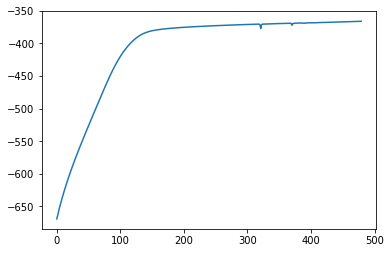

predicted rank with beta [ 0  1  2  3  4  8  5  6  7 10  9 12 11 13 14 15 16 18 17 19] [-0.89081067 -0.66844475 -0.61248618 -0.57585603 -0.35041174 -0.14999808
 -0.14812824 -0.14180008 -0.10052347 -0.06127381  0.10826956  0.12397636
  0.12934756  0.34108093  0.45782501  0.48460123  0.58807093  0.5911231
  0.61149144  1.16877651] beta [ 0.27085665  0.57076091  0.00767314  0.80203056  0.18123285]


NameError: name 'acc_func' is not defined

In [28]:
%%time

def train_func_torchy_noisy(data_pack, int_seed=3813, max_iter=500, lr=1e-3, opt_func=torch.optim.SGD):
    data, n_items, n_judges, n_pairs = data_pack
    torch.manual_seed(int_seed)
    s = Variable(torch.randn(n_items).type(dtypeF), requires_grad=True)
    eps = Variable(torch.randn(n_judges).type(dtypeF), requires_grad=True)
    print('initial: s, eps', s.data.numpy(), np.tanh(eps.data.numpy())**2)
    s.data /= torch.sum(s.data)
    
    params = [s, eps]
    optimizer = opt_func(params, lr=lr)
    
    # print(s)
    p_list = []
    p_noreg_list = []
    for iter_num in range(max_iter):
    #     print(iter_num)
        np.random.shuffle(data)
        
        p = 0
        p_noreg = 0
        for i, j, k in data:
            p += -torch.log(torch.exp((s[j] - s[i]) / torch.tanh(eps[k]) / torch.tanh(eps[k])) + 1)

        p_noreg_list.append(np.array(p.data)[0])
        p += - s.pow(2).sum() - eps.pow(2).sum()
        p_list.append(np.array(p.data)[0])

        optimizer.zero_grad()
        p = -p
        p.backward()
        optimizer.step()
        
    res_s = s.data.cpu().numpy()
    res_eps = eps.data.cpu().numpy()
    rank = np.argsort(res_s)
    plt.plot(p_list[20:])
    plt.show()
#     plt.plot(p_noreg_list)
#     plt.show()
    print('predicted rank with beta', rank, res_s[rank], 'beta', np.tanh(res_eps)**2)
    return acc_func(rank)

train_func_torchy_noisy(data_pack=data_pack, max_iter=500, lr=1*1e-4, opt_func=torch.optim.ASGD)

In [27]:
np.random.normal(0, 1e-4, size=8)

array([ -3.19464890e-05,  -1.43640771e-05,  -1.09915600e-06,
         3.05165264e-04,  -9.29369429e-05,   6.22572413e-05,
         2.42255951e-06,   4.12307110e-05])

In [ ]:
%%time
train_func_torchy_noisy(data_pack=data_pack, max_iter=1000, lr=5*1e-3, opt_func=torch.optim.Adam)

In [ ]:
%%time
train_func_torchy_noisy(int_seed=3838, data_pack=data_pack, max_iter=1000, lr=5*1e-3, opt_func=torch.optim.Adam)

In [ ]:
%%time
def train_func_torchy_eta_hack(data, int_seed=3813, max_iter=500, lr=1e-3, opt_func=torch.optim.SGD):
    torch.manual_seed(int_seed)
    s = Variable(torch.randn(n_items).type(dtypeF), requires_grad=True)
    eps = Variable(torch.randn(n_judges).type(dtypeF), requires_grad=True)
    # print(s,i,j)
    s.data /= torch.sum(s.data)
    
    params = [s, eps]
    optimizer = opt_func(params, lr=lr)
    
    # print(s)
    p_list = []
    p_noreg_list = []
    for iter_num in range(max_iter):
    #     print(iter_num)
        np.random.shuffle(data)
        
        p = 0
        p_noreg = 0
        for i, j, k in data:
            
            eta = torch.tanh(eps[k]) ** 2
            diff = (s[j] - s[i])
            p += - eta * torch.log(torch.exp(diff) + 1) - (1 - eta) * torch.log(torch.exp(-diff) + 1)

        p_noreg_list.append(np.array(p.data)[0])
        p += - s.pow(2).sum() - eps.pow(2).sum()
        p_list.append(np.array(p.data)[0])

        optimizer.zero_grad()
        p = -p
        p.backward()
        optimizer.step()
        
    res_s = s.data.cpu().numpy()
    res_eps = eps.data.cpu().numpy()
    rank = np.argsort(res_s)
    plt.plot(p_list[20:])
    plt.show()
#     plt.plot(p_noreg_list)
#     plt.show()
    print('predicted rank with eta', rank, res_s[rank], 'eta', np.tanh(res_eps)**2)

train_func_torchy(data=data, max_iter=1000, lr=1e-3, opt_func=torch.optim.ASGD)